# Anomalous sound detection : supervised classification of normal/anomalous sounds with machine learning techniques

In [1]:
import librosa
import IPython.display as ipd
import librosa.display
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, f_classif
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
#%matplotlib notebook
%matplotlib inline

In [2]:
# Enter the data path
PATH_DATASET = "../data/data"

Function to create dataframes for all machine types containing the filename of each sample, its section, its attribute and type of sound.

In [3]:
def build_dataframe(machine_str = 'valve'):
    #Get list of files in train and test directory
    path_train_folder = PATH_DATASET + "/dev_" + machine_str + "/" + machine_str + "/train"
    path_test_folder = PATH_DATASET  + "/dev_" + machine_str + "/" + machine_str + "/test"

    train_files = [f for f in os.listdir(path_train_folder)]
    test_files = [f for f in os.listdir(path_test_folder)]

    #Get list of dictionnary for creating DataFrame
    list_dict_file = []

    #Loop through filenames
    for filename in train_files:

        #Get filename as list of string
        splitted_filename = filename.split('_')

        #Append dictionnary to list
        list_dict_file.append({
            'filepath' : path_train_folder + "/" + filename,
            'filename' : filename,
            'section' : int(splitted_filename[1]),
            'domain_env' : splitted_filename[2],
            'dir' : splitted_filename[3],
            'sound_type' : splitted_filename[4],
            'id' : splitted_filename[5],
            'suffix' : '_'.join(splitted_filename[6:]).split('.wav')[0]  
        })

    #Loop through filenames
    for filename in test_files:

        #Get filename as list of string
        splitted_filename = filename.split('_')

        #Append dictionnary to list
        list_dict_file.append({
            'filepath' : path_test_folder  + "/" + filename,
            'filename' : filename,
            'section' : int(splitted_filename[1]),
            'domain_env' : splitted_filename[2],
            'dir' : splitted_filename[3],
            'sound_type' : splitted_filename[4],
            'id' : splitted_filename[5],
            'suffix' : '_'.join(splitted_filename[6:]).split('.wav')[0] 
        })
        
    return pd.DataFrame(list_dict_file)


def sound_from_file(filename, machine_str = 'valve', dataset = 'train'):
    df = build_dataframe(machine_str)
    path = PATH_DATASET + "/dev_" + machine_str + "/" + machine_str + "/" + dataset + "/" + filename
    return df[df['filepath']==path].iloc[0]
    


df_fan = build_dataframe('fan')
df_valve = build_dataframe('valve')
df_bearing = build_dataframe('bearing')
df_slider = build_dataframe('slider')
df_car = build_dataframe('ToyCar')
df_train = build_dataframe('ToyTrain')
df_gearbox = build_dataframe('gearbox')

df_fan.info()
df_gearbox.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filepath    3600 non-null   object
 1   filename    3600 non-null   object
 2   section     3600 non-null   int64 
 3   domain_env  3600 non-null   object
 4   dir         3600 non-null   object
 5   sound_type  3600 non-null   object
 6   id          3600 non-null   object
 7   suffix      3600 non-null   object
dtypes: int64(1), object(7)
memory usage: 225.1+ KB


,filepath,filename,section,domain_env,dir,sound_type,id,suffix
0,../data/data/dev_gearbox/gearbox/train/section...,section_00_source_train_normal_0000_volt_1.0.wav,0,source,train,normal,0000,volt_1.0
1,../data/data/dev_gearbox/gearbox/train/section...,section_00_source_train_normal_0001_volt_2.5.wav,0,source,train,normal,0001,volt_2.5
2,../data/data/dev_gearbox/gearbox/train/section...,section_00_source_train_normal_0002_volt_1.5.wav,0,source,train,normal,0002,volt_1.5
3,../data/data/dev_gearbox/gearbox/train/section...,section_00_source_train_normal_0003_volt_2.0.wav,0,source,train,normal,0003,volt_2.0
4,../data/data/dev_gearbox/gearbox/train/section...,section_00_source_train_normal_0004_volt_1.0.wav,0,source,train,normal,0004,volt_1.0


Function to get the data matrix of amplitude spectrograms and the data matrix of phase spectrograms from a dataframe 

In [4]:
def load_audio(file_path):
    y, sr = librosa.load(file_path, sr = None)
    return y, sr

def spectrogram(audio, n_fft = 1024, hop_length = 512):
    spectrum = librosa.stft(audio, n_fft = n_fft, hop_length = hop_length, center = False)
    # Chose center = False above after doing a test on a simple superposition of two sin with two frequencies
    # There are boundary artifacts in the spectrograms if center = True
    # Not investigated why it is like this but the spectrograms look definitely better with center = False
    # To be confirmed
    magnitude, phase = librosa.magphase(spectrum)
    magnitude_in_db = librosa.amplitude_to_db(magnitude, ref=1e-6)
    # or ref=np.max. ref = 1e-6 corresponds to the threshold intensity for humans = 1e-12 W/m2
    # Not sure of the units. Does not matter, I just want a fixed ref for all spectrograms
    return magnitude_in_db, np.angle(phase)    

def get_spectros_from_df(df, n_fft = 1024, hop_length = 512):
    def path_to_spectra(path):
        y, sr = load_audio(path)
        mag_sp, phase_sp = spectrogram(y, n_fft = n_fft, hop_length = hop_length)
        return mag_sp.flatten(), phase_sp.flatten()     
    
    filepaths = df['filepath'].reset_index(drop = True)
    X_tmp = path_to_spectra(filepaths.iloc[0])[0]     # to get the size of a flatten spectrum
    X_mag = np.empty((filepaths.shape[0], X_tmp.size))
    X_phase = np.empty((filepaths.shape[0], X_tmp.size))
                   
    for i, path in filepaths.items():
        mag_sp, phase_sp = path_to_spectra(path)
        X_mag[i] = mag_sp
        X_phase[i] = phase_sp

    return X_mag, X_phase
                                                                                
    
#X_mag, X_phase = get_spectros_from_df(df_gearbox[(df_gearbox['dir']=='test') & (df_gearbox['section']==0)])



## Choose data

In [5]:
# Choose the machine
machine_str = 'gearbox'

# Fix the parameters
params = dict(n_fft = 1024,        # n_fft paramater for calculating the spectrograms with librosa.stft
              hop_length = 512     # hop_length paramater for calculating the spectrograms with librosa.stft
             )

In [6]:
df = build_dataframe(machine_str)

df_normal = df[df['sound_type']=='normal'].sample(n = 500, random_state = 1)
df_anormal = df[df['sound_type']=='anomaly'].sample(n = 300, random_state = 1)
data = pd.concat([df_normal, df_anormal], axis = 0).reset_index()

X_mag, X_phase = get_spectros_from_df(data, n_fft = params['n_fft'], hop_length = params['hop_length'])

target = data['sound_type']
target = target.replace(to_replace = ['normal', 'anomaly'], value = [0, 1])

## Split in training and test sets

In [7]:
# Choose here if the training is done on the amplitude spectrogram, phase spectrogram or both
which = 'amplitude'      # 'amplitude', 'phase', or 'both'

In [8]:
def my_train_test_split(X_mag, X_phase, target, which = 'amplitude', test_size = 0.2, random_state = 123):
    if which == 'amplitude':
        X = X_mag
    elif which == 'phase':
        X = X_phase
    elif which == 'both':
        X = np.concatenate([X_mag, X_phase], axis = 1)
    else:
        raise ValueError("'which' must be equal to 'amplitude', 'phase' or 'both'")
        
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size = test_size, random_state = random_state)
    
    return X_train, X_test, y_train, y_test


In [9]:
X_train, X_test, y_train, y_test = my_train_test_split(X_mag, X_phase, target, which = which)

In the following, we test different dimensionality reduction and machine learning approaches. Choose the cells to be run.

## Without dimensionality reduction
We keep the whole spectrogram(s) for each sound

In [10]:
X_red_train, X_red_test = X_train, X_test

## Dimensionality reduction

#### First try: reduce the spectrograms per column by keeping some key features of the frequency distribution (at each time)

In [11]:
# We reduce the number of features by computing the means of the spectrograms per column
def dim_reduce_by_spcol(X_train, X_test, n_fft = 1024, \
                        mean = True, median = False, mini = False, maxi = False, std = False):
    # Reshape 2D X_train, X_test to 3D arrays ie unflatten the spectrograms
    # The number of lines in the original spectrogram is 1 + int(n_fft/2)
    X_train = np.reshape(X_train, (X_train.shape[0], 1 + int(n_fft/2), -1))    
    X_test = np.reshape(X_test, (X_test.shape[0], 1 + int(n_fft/2), -1))

    X_train_red = np.empty((X_train.shape[0], 0))
    X_test_red = np.empty((X_test.shape[0], 0))
    if mean:
        X_train_red  = np.hstack([X_train_red, np.mean(X_train, axis = 1)])
        X_test_red  = np.hstack([X_test_red, np.mean(X_test, axis = 1)])
    if median:
        X_train_red  = np.hstack([X_train_red, np.median(X_train, axis = 1)])
        X_test_red  = np.hstack([X_test_red, np.median(X_test, axis = 1)])
    if mini:
        X_train_red  = np.hstack([X_train_red, np.amin(X_train, axis = 1)])
        X_test_red  = np.hstack([X_test_red, np.amin(X_test, axis = 1)])
    if maxi:
        X_train_red  = np.hstack([X_train_red, np.amax(X_train, axis = 1)])
        X_test_red  = np.hstack([X_test_red, np.amax(X_test, axis = 1)])
    if std:
        X_train_red  = np.hstack([X_train_red, np.std(X_train, axis = 1)])
        X_test_red  = np.hstack([X_test_red, np.std(X_test, axis = 1)])

    return X_train_red, X_test_red

In [12]:
# Choose how to reduce the spectrograms
params_red = dict(mean = True,
                  median = False,
                  mini = False,
                  maxi = False,
                  std = True
                 )

X_red_train, X_red_test = dim_reduce_by_spcol(X_train, X_test, n_fft = params['n_fft'], **params_red)

print(X_red_train.shape)
print(X_train.shape)

(640, 622)
(640, 159543)


#### Second try: first feature selection, then PCA

In [13]:
'''
sel = VarianceThreshold(threshold = 1e-2)
sel.fit(X_train)
print("Nombre de features conservées =", sel.get_support().sum())
print("Nombre de features totales =", X_train.shape[1])
'''

'\nsel = VarianceThreshold(threshold = 1e-2)\nsel.fit(X_train)\nprint("Nombre de features conservées =", sel.get_support().sum())\nprint("Nombre de features totales =", X_train.shape[1])\n'

This is useless because all features are kept even for threshold = 0.01. Let's try to do filtering with SelectPercentile

In [14]:
sel = SelectPercentile(score_func = f_classif, percentile = 30)
sel.fit(X_train, y_train)
X_red_train = sel.transform(X_train)
X_red_test = sel.transform(X_test)

I've tested different values of percentile for 'which'='amplitude' and compare the test AUCs obtained with xgboost. I find "experimentally" that percentile = 30 is the best choice to maximize the test AUC. However this should be done in a cleaner way by plotting eg AUC vs percentile. 



In [15]:
n_feats = X_red_train.shape[1]
pca = PCA(n_components = 0.85)       # keep 85% of variance
pca.fit(X_red_train)
X_red_train = pca.transform(X_red_train)
X_red_test = pca.transform(X_red_test)

print("Number of initial features = ", n_feats)
print("Number of selected features = ", pca.n_components_)

Number of initial features =  47863
Number of selected features =  448


I find empirically that n_components = 0.85 is a good choice (looking at test AUC calculated with xgboost) but this should be done more rigorously

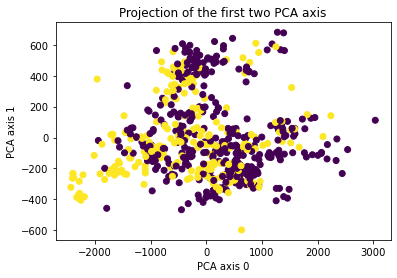

In [16]:
plt.scatter(X_red_train[:,0], X_red_train[:,1], c = y_train)
plt.xlabel("PCA axis 0")
plt.ylabel("PCA axis 1")
plt.title("Projection of the first two PCA axis");

## Machine learning

#### First classification method : Gradient Boosting

In [17]:
# Convert arrays to DMatrices
M_red_train = xgb.DMatrix(X_red_train, y_train)
M_red_test = xgb.DMatrix(X_red_test, y_test)

In [18]:
# Training
params_xgb = {'booster': 'gbtree',
              'learning_rate': 0.3,
              'alpha': 0.001,     # L1 regularization term
              'eval_metric': 'error',
              'objective': 'binary:logistic'}

xgb_model = xgb.train(dtrain = M_red_train, params = params_xgb, num_boost_round = 1000, \
                      early_stopping_rounds = 20, evals = [(M_red_train, 'train'), (M_red_test, 'test')])

train_pred_probas = xgb_model.predict(M_red_train, iteration_range = (0, xgb_model.best_iteration + 1))
train_preds = pd.Series(np.where(train_pred_probas>0.5, 1, 0))

test_pred_probas = xgb_model.predict(M_red_test, iteration_range = (0, xgb_model.best_iteration + 1))
test_preds = pd.Series(np.where(test_pred_probas>0.5, 1, 0))



[0]	train-error:0.11094	test-error:0.18750
[1]	train-error:0.06563	test-error:0.21250
[2]	train-error:0.05625	test-error:0.18750
[3]	train-error:0.05000	test-error:0.18750
[4]	train-error:0.02344	test-error:0.16875
[5]	train-error:0.01250	test-error:0.16875
[6]	train-error:0.00469	test-error:0.16875
[7]	train-error:0.00000	test-error:0.17500
[8]	train-error:0.00000	test-error:0.16250
[9]	train-error:0.00000	test-error:0.16250
[10]	train-error:0.00000	test-error:0.14375
[11]	train-error:0.00000	test-error:0.13750
[12]	train-error:0.00000	test-error:0.13125
[13]	train-error:0.00000	test-error:0.13125
[14]	train-error:0.00000	test-error:0.13750
[15]	train-error:0.00000	test-error:0.13125
[16]	train-error:0.00000	test-error:0.13125
[17]	train-error:0.00000	test-error:0.13125
[18]	train-error:0.00000	test-error:0.13125
[19]	train-error:0.00000	test-error:0.12500
[20]	train-error:0.00000	test-error:0.12500
[21]	train-error:0.00000	test-error:0.12500
[22]	train-error:0.00000	test-error:0.1187

Clearly, the model is overfitting since the train_error is vanishing. Let's try to play with the parameter subsample (fraction of observations (the rows) to subsample at each step) to reduce this effect. 

In [19]:
ratios = np.linspace(0, 1, 10)

train_errors = []    # list to store train errors
test_errors = []    # list to store test errors
for ratio in ratios:    
    params_xgb = {'booster': 'gbtree',
          'learning_rate': 1,
          'alpha': 0.001,     # L1 regularization term
          'subsample': ratio,
          'eval_metric': 'error',
          'objective': 'binary:logistic'}

    xgb_model = xgb.train(dtrain = M_red_train, params = params_xgb, num_boost_round = 1000, \
                  early_stopping_rounds = 20, evals = [(M_red_train, 'train'), (M_red_test, 'test')], \
                  verbose_eval = False)
    
    train_pred_probas = xgb_model.predict(M_red_train, iteration_range = (0, xgb_model.best_iteration + 1))
    train_preds = pd.Series(np.where(train_pred_probas>0.5, 1, 0))
    train_error = 1 - accuracy_score(y_train, train_preds)
    
    test_pred_probas = xgb_model.predict(M_red_test, iteration_range = (0, xgb_model.best_iteration + 1))
    test_preds = pd.Series(np.where(test_pred_probas>0.5, 1, 0))
    test_error = 1 - accuracy_score(y_test, test_preds)
    
    train_errors.append(train_error)
    test_errors.append(test_error)

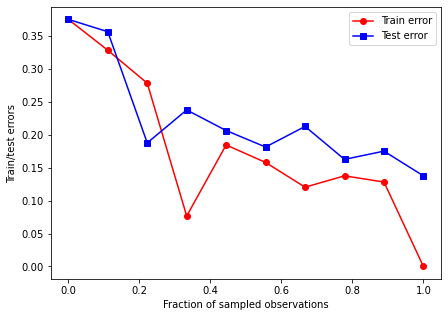

In [20]:
fig = plt.figure(figsize = (7, 5))
plt.plot(ratios, train_errors, 'r-o', label = 'Train error')
plt.plot(ratios, test_errors, 'b-s', label = 'Test error')
plt.xlabel("Fraction of sampled observations")
plt.ylabel("Train/test errors")
plt.legend()

Well, it doesn't seem to be a good idea to reduce subsample, hence in the following I keep subsample = 1 (default).

Let's try to adjust the parameters learning_rate and alpha

In [21]:
learning_rates = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
alphas = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

aucs = []    # list to store auc
for alpha in alphas:
    for learning_rate in learning_rates:
        params_xgb = {'booster': 'gbtree',
              'learning_rate': learning_rate,
              'alpha': alpha,     # L1 regularization term
              'eval_metric': 'error',
              'objective': 'binary:logistic'}

        xgb_model = xgb.train(dtrain = M_red_train, params = params_xgb, num_boost_round = 1000, \
                      early_stopping_rounds = 20, evals = [(M_red_train, 'train'), (M_red_test, 'test')], \
                      verbose_eval = False)

        pred_probas = xgb_model.predict(M_red_test, iteration_range = (0, xgb_model.best_iteration + 1))
        preds = pd.Series(np.where(pred_probas>0.5, 1, 0))
        auc = roc_auc_score(y_test, preds)
        aucs.append([alpha, learning_rate, auc])
 

        
        

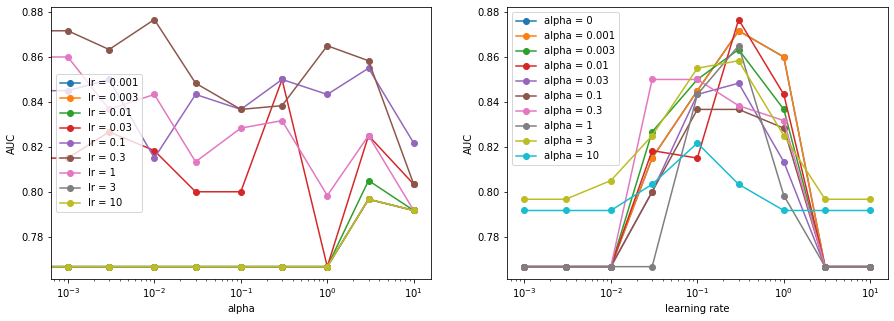

In [22]:
aucs = np.array(aucs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
for lr in learning_rates:
    aucs_lr = aucs[aucs[:,1]==lr]
    ax1.plot(aucs_lr[:,0], aucs_lr[:,2], "-o", label = "lr = " + str(lr))
    ax1.set_xlabel("alpha")
    ax1.set_ylabel("AUC")
    ax1.set_xscale('log')
    ax1.legend(loc = 'best')
    
for alpha in alphas:
    aucs_alpha = aucs[aucs[:,0]==alpha]
    ax2.plot(aucs_alpha[:,1], aucs_alpha[:,2], "-o", label = "alpha = " + str(alpha))
    ax2.set_xlabel("learning rate")
    ax2.set_ylabel("AUC")
    ax2.set_xscale('log')
    ax2.legend(loc = 'best')

Comments for reduction on cols (taking the mean per col) only and with which='both':

It is noteworthy that the AUC is independent of the learning rate value for alpha = 3. This is weird.

The best AUC is obtained for **learning_rate = 1 and alpha = 0.001**.

But actually this graphical study highly depends on the choice of 'which' and reduction method. This should be done automatically with a searchgrid.

#### Let's try with a SVM classifier

In [23]:
params_clf = {"kernel": ['linear'],  #['linear', 'poly'], \
              #"degree" : [2, 3, 4], \
              "C": [0.01, 0.05, 0.1, 0.2, 0.3, 1, 3, 5, 10, 20, 30, 50, 100]}
svmclf = svm.SVC()
gridsvm = GridSearchCV(svmclf, param_grid = params_clf, cv = 3, scoring = 'f1')
gridsvm.fit(X_red_train, y_train)
print("Best parameters = ", gridsvm.best_params_)
test_preds = gridsvm.predict(X_red_test)
train_preds = gridsvm.predict(X_red_train)

Best parameters =  {'C': 0.01, 'kernel': 'linear'}


#### Let's try with a Random Forest Classifier 

In [24]:
rfclf = RandomForestClassifier()
rfclf.fit(X_red_train, y_train)
test_preds = rfclf.predict(X_red_test)
train_preds = rfclf.predict(X_red_train)

#### Let's try with KNN

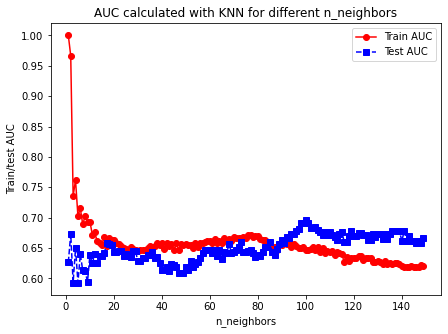

In [25]:
train_aucs = []
test_aucs = []
k_values = np.arange(1, 150, 1)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_red_train, y_train)
    test_preds = knn.predict(X_red_test)
    train_preds = knn.predict(X_red_train)
    test_auc = roc_auc_score(y_test, test_preds)
    train_auc = roc_auc_score(y_train, train_preds)
    test_aucs.append(test_auc)
    train_aucs.append(train_auc)
    
fig = plt.figure(figsize = (7, 5))
plt.plot(k_values, train_aucs, 'r-o', label = 'Train AUC')
plt.plot(k_values, test_aucs, 'b--s', label = 'Test AUC')
plt.xlabel("n_neighbors")
plt.ylabel("Train/test AUC")
plt.title("AUC calculated with KNN for different n_neighbors")
plt.legend()


#### Let's try with Logistic Regression

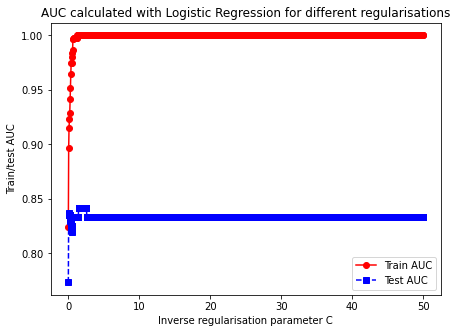

In [26]:
train_aucs = []
test_aucs = []
C_values = np.linspace(0.01, 50, 1000)

scaler = preprocessing.StandardScaler()
scaler.fit(X_red_train)
X_red_train_scaled = scaler.transform(X_red_train)
X_red_test_scaled = scaler.transform(X_red_test)

for C in C_values:
    lrclf = LogisticRegression(C = C, max_iter = 1000)
    lrclf.fit(X_red_train_scaled, y_train)
    test_preds = lrclf.predict(X_red_test_scaled)
    train_preds = lrclf.predict(X_red_train_scaled)
    test_auc = roc_auc_score(y_test, test_preds)
    train_auc = roc_auc_score(y_train, train_preds)
    test_aucs.append(test_auc)
    train_aucs.append(train_auc)
    
fig = plt.figure(figsize = (7, 5))
plt.plot(C_values, train_aucs, 'r-o', label = 'Train AUC')
plt.plot(C_values, test_aucs, 'b--s', label = 'Test AUC')
plt.xlabel("Inverse regularisation parameter C")
plt.ylabel("Train/test AUC")
plt.title("AUC calculated with Logistic Regression for different regularisations")
plt.legend()

#### Let's try with a voting classifier

In [27]:
clf1 = KNeighborsClassifier(n_neighbors = 20)
clf2 = svm.SVC(kernel = 'linear', C = 1)

vclf = VotingClassifier(estimators = [('KNN', clf1), ('SVM', clf2)], voting = 'hard')
vclf.fit(X_red_train, y_train)
test_preds = vclf.predict(X_red_test)
train_preds = vclf.predict(X_red_train)



Apparently, this does not improve the AUC with respect to svm alone.

#### With a stacking classifier

In [28]:
clf1 = KNeighborsClassifier(n_neighbors = 20)
clf2 = svm.SVC(kernel = 'linear', C = 1)

sclf = StackingClassifier(estimators = [('KNN', clf1), ('SVM', clf2)], final_estimator = clf1)
sclf.fit(X_red_train, y_train)
test_preds = sclf.predict(X_red_test)
train_preds = sclf.predict(X_red_train)

Very bad!

## Performance evaluation

In [29]:

test_f1_score_0 = f1_score(y_test, test_preds, pos_label = 0)
test_f1_score_1 = f1_score(y_test, test_preds, pos_label = 1)
train_f1_score_0 = f1_score(y_train, train_preds, pos_label = 0)
train_f1_score_1 = f1_score(y_train, train_preds, pos_label = 1)
test_auc = roc_auc_score(y_test, test_preds)
train_auc = roc_auc_score(y_train, train_preds)

print("f1 score of class 0 on test set = ", np.round(test_f1_score_0, 3))
print("f1 score of class 1 on test set = ", np.round(test_f1_score_1, 3))
print("f1 score of class 0 on train set = ", np.round(train_f1_score_0, 3))
print("f1 score of class 1 on train set = ", np.round(train_f1_score_1, 3))
print("Train AUC = ", np.round(train_auc, 3))
print("Test AUC = ", np.round(test_auc, 3))

#pd.crosstab(y_test.values, test_preds.values, rownames = ['Classe réelle'], colnames = ['Classe prédite'])
pd.crosstab(y_test, test_preds, rownames = ['Classe réelle'], colnames = ['Classe prédite'])

f1 score of class 0 on test set =  0.657
f1 score of class 1 on test set =  0.345
f1 score of class 0 on train set =  0.59
f1 score of class 1 on train set =  0.057
Train AUC =  0.352
Test AUC =  0.503


Classe prédite,0,1
Classe réelle,,
0,69,31
1,41,19


### Create a dataframe that I fill in manually to store the results  
This is not a good solution ... -> try MLFlow (or other tools) instead

In [30]:
col_names = ["machine",
             "section",
             "which_spectro", 
             "Reduction_method",
             "Reduction_params",
             "Classif_method",
             "Classif_params",
             "Train AUC",
             "Test AUC"]

results = pd.DataFrame(columns = col_names)

# 1st try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "phase", 
        "Reduction_method": "spectro cols",
        "Reduction_params": 'mean',
        "Classif_method": 'xgboost',
        "Classif_params": 'num_boost_r=1000, alpha=0.001, lr=1',
        "Train AUC": 1,
        "Test AUC": 0.48
        }

results.loc[len(results)] = line 

# 2nd try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "amplitude", 
        "Reduction_method": "spectro cols",
        "Reduction_params": 'mean',
        "Classif_method": 'xgboost',
        "Classif_params": 'num_boost_r=1000, alpha=0.001, lr=1',
        "Train AUC": 0.999,
        "Test AUC": 0.608
        }

results.loc[len(results)] = line 

# 3rd try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "both", 
        "Reduction_method": "spectro cols",
        "Reduction_params": 'mean',
        "Classif_method": 'xgboost',
        "Classif_params": 'num_boost_r=1000, alpha=0.001, lr=1',
        "Train score": 1,
        "Train AUC": 1,
        "Test AUC": 0.64
        }

results.loc[len(results)] = line

# 4th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "amplitude", 
        "Reduction_method": "spectro cols",
        "Reduction_params": 'mean+med',
        "Classif_method": 'xgboost',
        "Classif_params": 'num_boost_r=1000, alpha=0.001, lr=1',
        "Train AUC": 1,
        "Test AUC": 0.687
        }

results.loc[len(results)] = line 

# 5th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "amplitude", 
        "Reduction_method": "spectro cols",
        "Reduction_params": "mean+med+min+max",
        "Classif_method": 'xgboost',
        "Classif_params": 'num_boost_r=1000, alpha=0.001, lr=1',
        "Train AUC": 1,
        "Test AUC": 0.585
        }

results.loc[len(results)] = line 

# 6th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "phase", 
        "Reduction_method": "spectro cols",
        "Reduction_params": "mean+med+min+max",
        "Classif_method": 'xgboost',
        "Classif_params": 'num_boost_r=1000, alpha=0.001, lr=1',
        "Train AUC": 1,
        "Test AUC": 0.543
        }

results.loc[len(results)] = line 

# 7th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "phase", 
        "Reduction_method": "spectro cols",
        "Reduction_params": "mean+med",
        "Classif_method": 'xgboost',
        "Classif_params": 'num_boost_r=1000, alpha=0.001, lr=1',
        "Train AUC": 1,
        "Test AUC": 0.482
        }

results.loc[len(results)] = line 

# 7th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "amplitude", 
        "Reduction_method": "spectro cols",
        "Reduction_params": "mean+med+std",
        "Classif_method": 'xgboost',
        "Classif_params": 'num_boost_r=1000, alpha=0.001, lr=1',
        "Train AUC": 1,
        "Test AUC": 0.685
        }

results.loc[len(results)] = line 

# 8th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "amplitude", 
        "Reduction_method": "spectro cols",
        "Reduction_params": "mean+std",
        "Classif_method": 'xgboost',
        "Classif_params": 'num_boost_r=1000, alpha=0.001, lr=1',
        "Train AUC": 1,
        "Test AUC": 0.672
        }

results.loc[len(results)] = line 

# 9th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "both", 
        "Reduction_method": "spectro cols",
        "Reduction_params": "mean+std",
        "Classif_method": 'xgboost',
        "Classif_params": 'num_boost_r=1000, alpha=0.001, lr=1',
        "Train AUC": 0.917,
        "Test AUC": 0.588
        }

results.loc[len(results)] = line 

# 10th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "amplitude", 
        "Reduction_method": None,
        "Reduction_params": None,
        "Classif_method": 'xgboost',
        "Classif_params": 'num_boost_r=1000, alpha=0.001, lr=1',
        "Train AUC": 1,
        "Test AUC": 0.698
        }

results.loc[len(results)] = line 

# 11th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "both", 
        "Reduction_method": None,
        "Reduction_params": None,
        "Classif_method": 'xgboost',
        "Classif_params": 'num_boost_r=1000, alpha=0.001, lr=1',
        "Train AUC": 1,
        "Test AUC": 0.657
        }

results.loc[len(results)] = line 

# 12th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "phase", 
        "Reduction_method": None,
        "Reduction_params": None,
        "Classif_method": 'xgboost',
        "Classif_params": 'num_boost_r=1000, alpha=0.001, lr=1',
        "Train AUC": 1,
        "Test AUC": 0.565
        }

results.loc[len(results)] = line 

# 13th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "amplitude", 
        "Reduction_method": 'Percentile',
        "Reduction_params": "20%",
        "Classif_method": 'xgboost',
        "Classif_params": 'num_boost_r=1000, alpha=0.001, lr=1',
        "Train AUC": 1,
        "Test AUC": 0.718
        }

results.loc[len(results)] = line 

# 14th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "amplitude", 
        "Reduction_method": 'Percentile',
        "Reduction_params": "30%",
        "Classif_method": 'xgboost',
        "Classif_params": 'num_boost_r=1000, alpha=0.001, lr=1',
        "Train AUC": 1,
        "Test AUC": 0.767
        }

results.loc[len(results)] = line 

# 15th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "amplitude", 
        "Reduction_method": 'Percentile',
        "Reduction_params": "40%",
        "Classif_method": 'xgboost',
        "Classif_params": 'num_boost_r=1000, alpha=0.001, lr=1',
        "Train AUC": 1,
        "Test AUC": 0.677
        }

results.loc[len(results)] = line 

# 16th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "both", 
        "Reduction_method": 'Percentile',
        "Reduction_params": "30%",
        "Classif_method": 'xgboost',
        "Classif_params": 'num_boost_r=1000, alpha=0.001, lr=1',
        "Train AUC": 1,
        "Test AUC": 0.747
        }

results.loc[len(results)] = line 

# 17th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "amplitude", 
        "Reduction_method": 'Percentile + PCA',
        "Reduction_params": "perc : 30%; pca : 95%",
        "Classif_method": 'xgboost',
        "Classif_params": 'num_boost_r=1000, alpha=0.001, lr=1',
        "Train AUC": 1,
        "Test AUC": 0.788
        }

results.loc[len(results)] = line 

# 18th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "amplitude", 
        "Reduction_method": 'Percentile + PCA',
        "Reduction_params": "perc : 30%; pca : 90%",
        "Classif_method": 'xgboost',
        "Classif_params": 'num_boost_r=1000, alpha=0.001, lr=1',
        "Train AUC": 1,
        "Test AUC": 0.847
        }

results.loc[len(results)] = line 

# 19th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "amplitude", 
        "Reduction_method": 'Percentile + PCA',
        "Reduction_params": "perc : 30%; pca : 80%",
        "Classif_method": 'xgboost',
        "Classif_params": 'num_boost_r=1000, alpha=0.001, lr=1',
        "Train AUC": 0.857,
        "Test AUC": 0.767
        }

results.loc[len(results)] = line 

# 19th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "amplitude", 
        "Reduction_method": 'Percentile + PCA',
        "Reduction_params": "perc : 30%; pca : 85%",
        "Classif_method": 'xgboost',
        "Classif_params": 'num_boost_r=1000, alpha=0.001, lr=1',
        "Train AUC": 1,
        "Test AUC": 0.86
        }

results.loc[len(results)] = line 

# 20th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "both", 
        "Reduction_method": 'Percentile + PCA',
        "Reduction_params": "perc : 30%; pca : 85%",
        "Classif_method": 'xgboost',
        "Classif_params": 'num_boost_r=1000, alpha=0.001, lr=1',
        "Train AUC": 1,
        "Test AUC": 0.887
        }

results.loc[len(results)] = line 

# 21th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "amplitude", 
        "Reduction_method": 'Percentile + PCA',
        "Reduction_params": "perc : 30%; pca : 85%",
        "Classif_method": 'xgboost',
        "Classif_params": 'num_boost_r=1000, alpha=0.01, lr=0.3',
        "Train AUC": 1,
        "Test AUC": 0.877
        }

results.loc[len(results)] = line 

# 22th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "both", 
        "Reduction_method": 'Percentile + PCA',
        "Reduction_params": "perc : 30%; pca : 85%",
        "Classif_method": 'xgboost',
        "Classif_params": 'num_boost_r=1000, alpha=0.001, lr=0.3',
        "Train AUC": 1,
        "Test AUC": 0.903
        }

results.loc[len(results)] = line

# 22th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "phase", 
        "Reduction_method": 'Percentile + PCA',
        "Reduction_params": "perc : 30%; pca : 85%",
        "Classif_method": 'xgboost',
        "Classif_params": 'num_boost_r=1000, alpha=0.001, lr=0.3',
        "Train AUC": 1,
        "Test AUC": 0.5
        }

results.loc[len(results)] = line

# 23th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "amplitude", 
        "Reduction_method": 'Percentile + PCA',
        "Reduction_params": "perc : 30%; pca : 85%",
        "Classif_method": 'svm',
        "Classif_params": 'linear, C=1',
        "Train AUC": 1,
        "Test AUC": 0.82
        }

results.loc[len(results)] = line

# 23th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "amplitude", 
        "Reduction_method": 'Percentile + PCA',
        "Reduction_params": "perc : 30%; pca : 85%",
        "Classif_method": 'svm',
        "Classif_params": "C=0.1, gamma=0.001, kernel=poly",
        "Train AUC": 1,
        "Test AUC": 0.683
        }

results.loc[len(results)] = line

# 24th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "amplitude", 
        "Reduction_method": 'Percentile + PCA',
        "Reduction_params": "perc : 30%; pca : 85%",
        "Classif_method": 'svm',
        "Classif_params": "C=10, degree=2, kernel=poly",
        "Train AUC": 1,
        "Test AUC": 0.643
        }

results.loc[len(results)] = line

# 25th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "amplitude", 
        "Reduction_method": 'Percentile + PCA',
        "Reduction_params": "perc : 30%; pca : 85%",
        "Classif_method": 'Random Forest',
        "Classif_params": None,
        "Train AUC": 1,
        "Test AUC": 0.725
        }

results.loc[len(results)] = line

# 26th try ********************
line = {
        "machine": 'gearbox',
        "section": 'all',
        "which_spectro": "amplitude", 
        "Reduction_method": None,
        "Reduction_params": None,
        "Classif_method": 'Random Forest',
        "Classif_params": None,
        "Train AUC": 1,
        "Test AUC": 0.798
        }

results.loc[len(results)] = line


# Show the results
results.sort_values(by = 'Test AUC', ascending = False)

        

,machine,section,which_spectro,Reduction_method,Reduction_params,Classif_method,Classif_params,Train AUC,Test AUC
23,gearbox,all,both,Percentile + PCA,perc : 30%; pca : 85%,xgboost,"num_boost_r=1000, alpha=0.001, lr=0.3",1,0.903
21,gearbox,all,both,Percentile + PCA,perc : 30%; pca : 85%,xgboost,"num_boost_r=1000, alpha=0.001, lr=1",1,0.887
22,gearbox,all,amplitude,Percentile + PCA,perc : 30%; pca : 85%,xgboost,"num_boost_r=1000, alpha=0.01, lr=0.3",1,0.877
20,gearbox,all,amplitude,Percentile + PCA,perc : 30%; pca : 85%,xgboost,"num_boost_r=1000, alpha=0.001, lr=1",1,0.860
18,gearbox,all,amplitude,Percentile + PCA,perc : 30%; pca : 90%,xgboost,"num_boost_r=1000, alpha=0.001, lr=1",1,0.847
25,gearbox,all,amplitude,Percentile + PCA,perc : 30%; pca : 85%,svm,"linear, C=1",1,0.820
29,gearbox,all,amplitude,None,None,Random Forest,None,1,0.798
17,gearbox,all,amplitude,Percentile + PCA,perc : 30%; pca : 95%,xgboost,"num_boost_r=1000, alpha=0.001, lr=1",1,0.788
19,gearbox,all,amplitude,Percentile + PCA,perc : 30%; pca : 80%,xgboost,"num_boost_r=1000, alpha=0.001, lr=1",0.857,0.767
14,gearbox,all,amplitude,Percentile,30%,xgboost,"num_boost_r=1000, alpha=0.001, lr=1",1,0.767


### Check consistency of results

The best AUC ($AUC=0.903$) on the test set is obtained with:
* which='both' (but the improvement with respect to which='amplitude' is low, taking which='phase' is clearly bad)
* Feature Selection with SelectPercentile(percentile = 30) then PCA with n_components = 0.85
* xgboost (a quick and non-exhaustive investigation gives num_boost_r=1000, alpha=0.001, lr=0.3 for the best parameters, to be confirmed)

Now, we would like to check that this result is robust when we change the samples.

In [31]:
def compute_aucs_cv(machine_str, which, params, params_xgb):
    # Create features data and target
    df = build_dataframe(machine_str)

    df_normal = df[df['sound_type']=='normal'].sample(n = 500, random_state = 1)
    df_anormal = df[df['sound_type']=='anomaly'].sample(n = 300, random_state = 1)
    data = pd.concat([df_normal, df_anormal], axis = 0).reset_index()

    X_mag, X_phase = get_spectros_from_df(data, n_fft = params['n_fft'], hop_length = params['hop_length'])

    target = data['sound_type']
    target = target.replace(to_replace = ['normal', 'anomaly'], value = [0, 1])

    # Here I don't want to split in train and test splits and want to keep all the data for the cross-validation
    X_train, X_test, y_train, y_test = my_train_test_split(X_mag, X_phase, target, which = which, test_size = 0.01)

    # Reduction of dimensionality
    print("Number of initial features = ", X_train.shape[1])

    sel = SelectPercentile(score_func = f_classif, percentile = 30)
    sel.fit(X_train, y_train)
    X_red_train = sel.transform(X_train)
    #X_red_test = sel.transform(X_test)

    pca = PCA(n_components = 0.85)       # keep 85% of variance
    pca.fit(X_red_train)
    X_red_train = pca.transform(X_red_train)
    #X_red_test = pca.transform(X_red_test)

    print("Number of selected features after SelectPercentile + PCA = ", pca.n_components_)

    # Convert arrays to DMatrices
    M_red_train = xgb.DMatrix(X_red_train, y_train)
    #M_red_test = xgb.DMatrix(X_red_test, y_test)

    # Cross-val
    seeds = np.arange(50)
    test_aucs = []
    test_errors = []
    
    for seed in seeds:
        results_cv = xgb.cv(dtrain = M_red_train, params = params_xgb, num_boost_round = 1000, seed = seed, \
                            early_stopping_rounds = 20, metrics = ['auc', 'error'], nfold = 5)

        #display(results_cv)

        test_aucs.append([seed, results_cv['test-auc-mean'].max(), \
                          results_cv['test-auc-std'].iloc[results_cv['test-auc-mean'].argmax()]])
        test_errors.append([seed, results_cv['test-error-mean'].min(), \
                          results_cv['test-error-std'].iloc[results_cv['test-error-mean'].argmin()]])

    return np.array(test_aucs), np.array(test_errors)



In [32]:
# Choose the machine
machine_str = 'gearbox'

# Choose here if the training is done on the amplitude spectrogram, phase spectrogram or both
which = 'amplitude'      # 'amplitude', 'phase', or 'both'

# Fix the parameters
params = dict(n_fft = 1024,        # n_fft paramater for calculating the spectrograms with librosa.stft
              hop_length = 512     # hop_length paramater for calculating the spectrograms with librosa.stft
             )

params_xgb = {'booster': 'gbtree',
              'learning_rate': 0.3,
              'alpha': 0.01,     # L1 regularization term
              'eval_metric': 'error',
              'objective': 'binary:logistic'}

test_aucs_ampl, test_errors_ampl = compute_aucs_cv(machine_str, 'amplitude', params, params_xgb)
# Here I should change the optimized params_xgb for both (not done ...)
test_aucs_both, test_errors_both = compute_aucs_cv(machine_str, 'both', params, params_xgb)

Number of initial features =  159543
Number of selected features after SelectPercentile + PCA =  549
Number of initial features =  319086
Number of selected features after SelectPercentile + PCA =  564


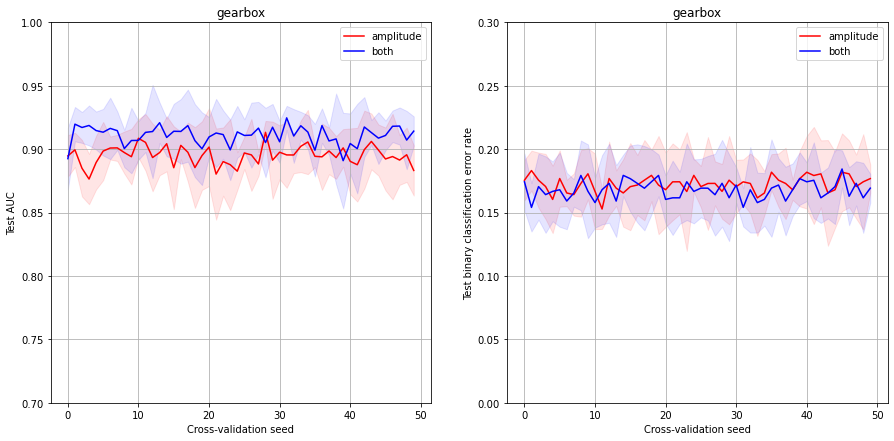

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7))

ax1.plot(test_aucs_ampl[:, 0], test_aucs_ampl[:, 1], 'r-', label = 'amplitude')
ax1.fill_between(test_aucs_ampl[:, 0], test_aucs_ampl[:, 1] - test_aucs_ampl[:, 2], \
                 test_aucs_ampl[:, 1] + test_aucs_ampl[:, 2], color='r', alpha=0.1)

ax1.plot(test_aucs_both[:, 0], test_aucs_both[:, 1], 'b-', label = 'both')
ax1.fill_between(test_aucs_both[:, 0], test_aucs_both[:, 1] - test_aucs_both[:, 2], \
                 test_aucs_both[:, 1] + test_aucs_both[:, 2], color='b', alpha=0.1)
ax1.set_xlabel("Cross-validation seed")
ax1.set_ylabel("Test AUC")
ax1.set_ylim([0.7, 1])
ax1.legend()
ax1.set_title('gearbox')
ax1.grid(True);

ax2.plot(test_errors_ampl[:, 0], test_errors_ampl[:, 1], 'r-', label = 'amplitude')
ax2.fill_between(test_errors_ampl[:, 0], test_errors_ampl[:, 1] - test_errors_ampl[:, 2], \
                 test_errors_ampl[:, 1] + test_errors_ampl[:, 2], color='r', alpha=0.1)

ax2.plot(test_errors_both[:, 0], test_errors_both[:, 1], 'b-', label = 'both')
ax2.fill_between(test_errors_both[:, 0], test_errors_both[:, 1] - test_errors_both[:, 2], \
                 test_errors_both[:, 1] + test_errors_both[:, 2], color='b', alpha=0.1)
ax2.set_xlabel("Cross-validation seed")
ax2.set_ylabel("Test binary classification error rate")
ax2.set_ylim([0, 0.3])
ax2.legend()
ax2.set_title('gearbox')
ax2.grid(True);

#### Repeat for another machine, with the same procedure (no optimization for this new machine)

In [34]:
test_aucs_ampl, test_errors_ampl = compute_aucs_cv('fan', 'amplitude', params, params_xgb)
test_aucs_both, test_errors_both = compute_aucs_cv('fan', 'both', params, params_xgb)

Number of initial features =  159543
Number of selected features after SelectPercentile + PCA =  437
Number of initial features =  319086
Number of selected features after SelectPercentile + PCA =  452


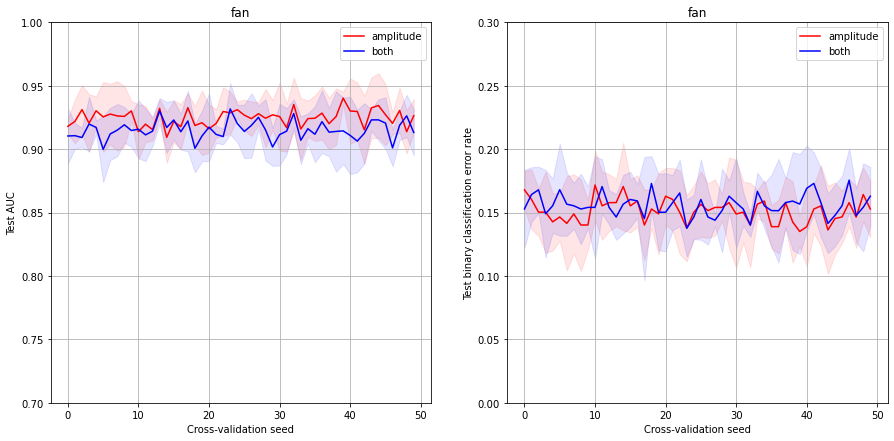

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7))

ax1.plot(test_aucs_ampl[:, 0], test_aucs_ampl[:, 1], 'r-', label = 'amplitude')
ax1.fill_between(test_aucs_ampl[:, 0], test_aucs_ampl[:, 1] - test_aucs_ampl[:, 2], \
                 test_aucs_ampl[:, 1] + test_aucs_ampl[:, 2], color='r', alpha=0.1)

ax1.plot(test_aucs_both[:, 0], test_aucs_both[:, 1], 'b-', label = 'both')
ax1.fill_between(test_aucs_both[:, 0], test_aucs_both[:, 1] - test_aucs_both[:, 2], \
                 test_aucs_both[:, 1] + test_aucs_both[:, 2], color='b', alpha=0.1)
ax1.set_xlabel("Cross-validation seed")
ax1.set_ylabel("Test AUC")
ax1.set_ylim([0.7, 1])
ax1.legend()
ax1.set_title('fan')
ax1.grid(True);

ax2.plot(test_errors_ampl[:, 0], test_errors_ampl[:, 1], 'r-', label = 'amplitude')
ax2.fill_between(test_errors_ampl[:, 0], test_errors_ampl[:, 1] - test_errors_ampl[:, 2], \
                 test_errors_ampl[:, 1] + test_errors_ampl[:, 2], color='r', alpha=0.1)

ax2.plot(test_errors_both[:, 0], test_errors_both[:, 1], 'b-', label = 'both')
ax2.fill_between(test_errors_both[:, 0], test_errors_both[:, 1] - test_errors_both[:, 2], \
                 test_errors_both[:, 1] + test_errors_both[:, 2], color='b', alpha=0.1)
ax2.set_xlabel("Cross-validation seed")
ax2.set_ylabel("Test binary classification error rate")
ax2.set_ylim([0, 0.3])
ax2.legend()
ax2.set_title('fan')
ax2.grid(True);

## Figure for the report

Remember that the optimization has been done for the gearbox only. Here we keep the same hyperparameters for the other machines.

In [36]:
# Fix the parameters
params = dict(n_fft = 1024,        # n_fft paramater for calculating the spectrograms with librosa.stft
              hop_length = 512     # hop_length paramater for calculating the spectrograms with librosa.stft
             )

params_xgb = {'booster': 'gbtree',
              'learning_rate': 0.3,
              'alpha': 0.01,     # L1 regularization term
              'eval_metric': 'error',
              'objective': 'binary:logistic'}

dict_results = {}
for machine in ['fan', 'gearbox', 'valve', 'ToyCar', 'ToyTrain', 'bearing', 'slider']:
    test_aucs_ampl, test_errors_ampl = compute_aucs_cv(machine, 'amplitude', params, params_xgb)
    dict_results[machine] = test_aucs_ampl, test_errors_ampl

Number of initial features =  159543
Number of selected features after SelectPercentile + PCA =  437
Number of initial features =  159543
Number of selected features after SelectPercentile + PCA =  549
Number of initial features =  159543
Number of selected features after SelectPercentile + PCA =  552
Number of initial features =  159543
Number of selected features after SelectPercentile + PCA =  557
Number of initial features =  159543
Number of selected features after SelectPercentile + PCA =  543
Number of initial features =  159543
Number of selected features after SelectPercentile + PCA =  594


In [38]:
# Save the results into a file 
np.save('dict_results_classif_PCAxgboost.npy', dict_results)

# To load the results
#new_dict = np.load('dict_results_classif_PCAxgboost.npy', allow_pickle='TRUE')

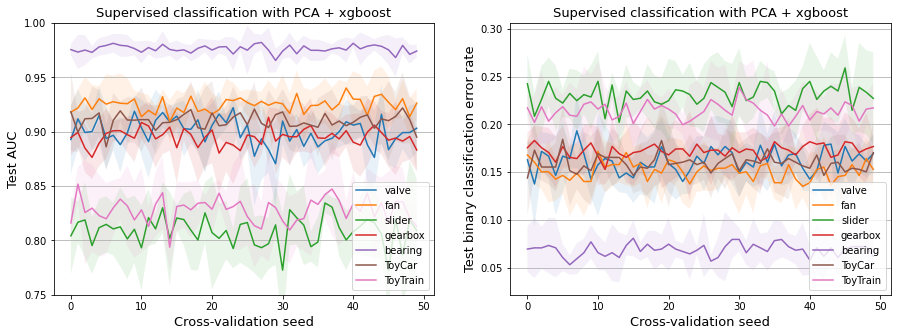

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

for machine in ['valve', 'fan', 'slider', 'gearbox', 'bearing', 'ToyCar', 'ToyTrain']:
    test_aucs_ampl, test_errors_ampl = dict_results[machine]
    ax1.plot(test_aucs_ampl[:, 0], test_aucs_ampl[:, 1], label = machine)
    ax1.fill_between(test_aucs_ampl[:, 0], test_aucs_ampl[:, 1] - test_aucs_ampl[:, 2], \
                     test_aucs_ampl[:, 1] + test_aucs_ampl[:, 2], alpha=0.1)
    
    ax2.plot(test_errors_ampl[:, 0], test_errors_ampl[:, 1], label = machine)
    ax2.fill_between(test_errors_ampl[:, 0], test_errors_ampl[:, 1] - test_errors_ampl[:, 2], \
                     test_errors_ampl[:, 1] + test_errors_ampl[:, 2], alpha=0.1)

ax1.set_xlabel("Cross-validation seed", fontsize = 13.0)
ax1.set_ylabel("Test AUC", fontsize = 13.0)
ax1.set_ylim([0.75, 1])
ax1.legend(loc = 'lower right')
ax1.grid(axis = 'y')
ax1.set_title("Supervised classification with PCA + xgboost", fontsize = 13.0)

ax2.set_xlabel("Cross-validation seed", fontsize = 13.0)
ax2.set_ylabel("Test binary classification error rate", fontsize = 13.0)
#ax2.set_ylim([0, 0.3])
ax2.legend(loc = 'lower right')
ax2.grid(axis = 'y')
ax2.set_title("Supervised classification with PCA + xgboost", fontsize = 13.0);

{'valve': 0.8997735320000001, 'gearbox': 0.8951146640000001, 'fan': 0.924612212, 'slider': 0.8089389359999999, 'bearing': 0.9761771399999999, 'ToyCar': 0.9098845280000001, 'ToyTrain': 0.8280282240000001}


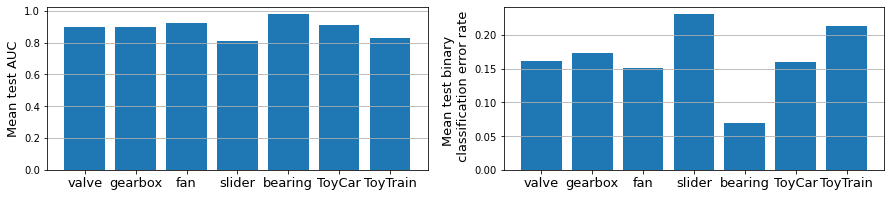

In [40]:
dict_aucs = {}
dict_errors = {}

for machine in ['valve', 'gearbox', 'fan', 'slider', 'bearing', 'ToyCar', 'ToyTrain']:
    test_aucs_ampl, test_errors_ampl = dict_results[machine]
    dict_aucs[machine] = test_aucs_ampl[:,1].mean()
    dict_errors[machine] = test_errors_ampl[:,1].mean()

print(dict_aucs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 3))

ax1.bar(range(7), dict_aucs.values())
ax1.set_xticks(range(7))
ax1.set_xticklabels(dict_aucs.keys(), fontsize = 13.0)
ax1.set_ylabel("Mean test AUC", fontsize = 13.0)
ax1.grid(True, axis = 'y')

ax2.bar(range(7), dict_errors.values())
ax2.set_xticks(range(7))
ax2.set_xticklabels(dict_errors.keys(), fontsize = 13.0)
ax2.set_ylabel("Mean test binary \n classification error rate", fontsize = 13.0)
ax2.grid(True, axis = 'y')


In [41]:
dict_results = np.load('dict_results_classif_PCAxgboost.npy', allow_pickle='TRUE')

In [42]:
test_aucs_ampl, test_errors_ampl = dict_results[()]['bearing']
print("AUC = ", test_aucs_ampl[:,1].mean())
print('Error =', test_errors_ampl[:,1].mean())

AUC =  0.9761771399999999
Error = 0.06873776399999999
